## Question 01

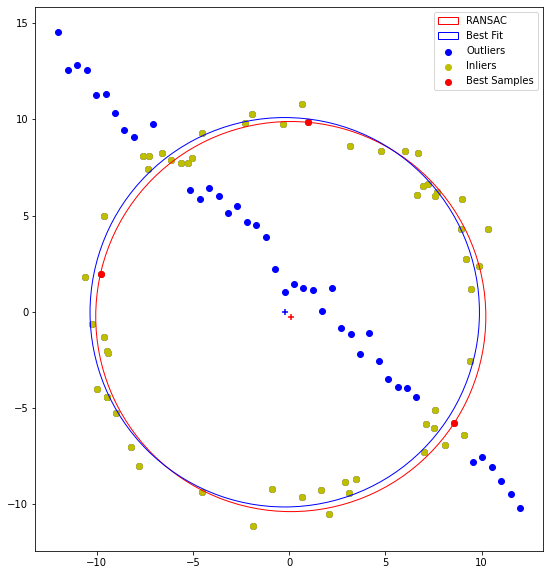

In [40]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
#np.random.seed(4)
N = 100
half_n = N//2
r = 10
sigma = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = sigma*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + sigma*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) 

def RANSAC_circle(points, threshold):
    n = points.shape[0] # number of points
    best_estimate = None; best_sample = None
    max_inliers = []
    p = 0.99; e = 0.5; N = np.log(1 - p) / np.log(1 - e**(n/10))
    for i in range(int(N)):
        random_index = np.random.randint(n, size=3) # get 3 random indexes
        pt1, pt2, pt3 = points[random_index] # get 3 points using random indexes
        A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
        B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
        C = np.linalg.pinv(A) @ B / 2
        a, b = C.flatten() # center cordinates of the selected circle
        r = np.sqrt((a - pt1[0])**2 + (b - pt1[1])**2) # calculating radius
        inliers = []
        for x, y in points: # to check each point with calculated circle.
            distance = np.sqrt((x - a)**2 + (y - b)**2)
            if (np.abs(distance - r) < threshold): inliers.append([x,y])# check wheather the point is lied within the threshold value
        if (len(inliers) > len(max_inliers)): best_estimate = (a, b, r); best_sample = random_index; max_inliers = inliers
    return best_estimate, max_inliers, best_sample
best_estimate, inliers, best_sample = RANSAC_circle(X, 1.96*sigma) # get the best estimate circle parameters
a, b, r = best_estimate[0], best_estimate[1], best_estimate[2]; inliers = np.array(inliers)
P = np.concatenate((inliers, np.ones((inliers.shape[0], 1))), axis=1) # Least Square
Q = inliers[:,[0]]**2 + inliers[:, [1]]**2
B = np.linalg.pinv(P.T @ P) @ P.T @ Q
a0, b0, c = B.flatten(); a0, b0 = a0/2, b0/2 # parameters of the best fitting circle
r0 = np.sqrt(a0**2 + b0**2 + c)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], c='blue', marker='o', label='Outliers')
ax.scatter(inliers[:, 0], inliers[:, 1], c='y', marker='o', label='Inliers')
ax.scatter(X[best_sample][:, 0], X[best_sample][:, 1], c='r', marker='o', label='Best Samples')
ax.scatter(a, b, c='r', marker='+')
ax.scatter(a0, b0, c='b', marker='+')
circle_best_sample = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False, label='RANSAC')
circle_best_fit = plt.Circle((a0, b0), radius=r0, color='b', fc='y', fill=False, label='Best Fit')
plt.gca().add_patch(circle_best_sample)
plt.gca().add_patch(circle_best_fit)
ax.legend()
ax.axis('scaled')
# plt.savefig('Report/images/ransac.png')
plt.show()

## Question 02

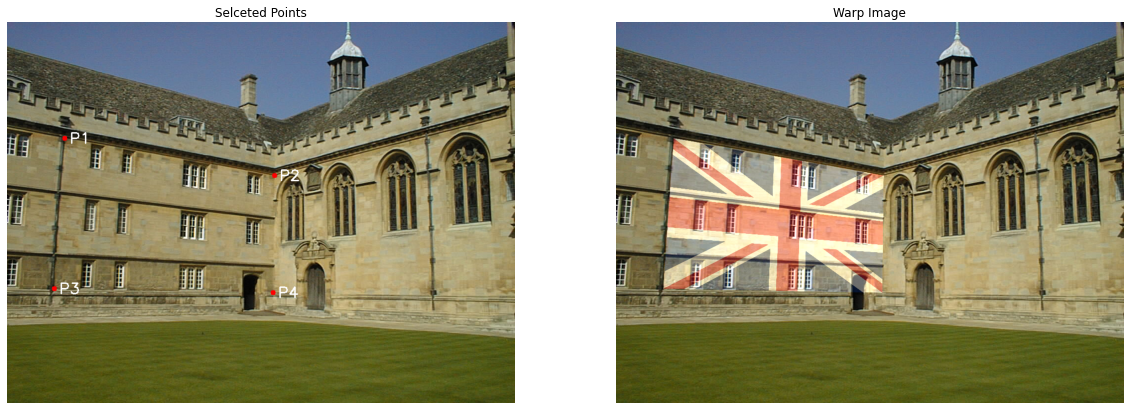

In [4]:
import cv2 as cv
def find_hormograpy(src_pts, dst_pts):
    n = src_pts.shape[0] # get the number of matches
    A = np.empty((2*n, 9)) 
    for i in range(n): # appending corresponding value to A matrix
        A[2*i] = [src_pts[i][0], src_pts[i][1], 1, 0, 0, 0, -dst_pts[i][0]*src_pts[i][0], -dst_pts[i][0]*src_pts[i][1], -dst_pts[i][0]]
        A[2*i+1] = [0, 0, 0, src_pts[i][0], src_pts[i][1], 1, -dst_pts[i][1]*src_pts[i][0], -dst_pts[i][1]*src_pts[i][1], -dst_pts[i][1]]
    W, V = np.linalg.eig(A.T @ A) # get the eigen values and eigen vectors of the A.T @ A
    ev_corresponding_to_smalest_ev = V[:, np.argmin(W)] # get the eigenvector associated with smallest eigenvalue
    return ev_corresponding_to_smalest_ev.reshape((3, 3)) # return the 3x3 homography matrix
Y = np.empty((0,2))
def click_event(event, x, y, flags, params): # define the clicking event
    global Y
    if event == cv.EVENT_LBUTTONDOWN and len(Y) < 4:
        Y = np.vstack((Y, [x, y])); font = cv.FONT_HERSHEY_SIMPLEX # draw small circle on click point
        cv.circle(img,(x,y), 5,(0,0,255),-1); cv.putText(img, "P{}".format(len(Y)), (x+10,y+10), font, 1, (255, 255, 255), 2); cv.imshow('image', img)  
img = cv.imread('002.jpg') # get background image
img_copy = img.copy() # keep a copy of the img to blend the flag
cv.imshow('image', img); cv.setMouseCallback('image', click_event); cv.waitKey(0); cv.destroyAllWindows()
uk_flag = cv.imread('uk_flag.png') # get the flag
shape = uk_flag.shape
X = np.array([[0, 0], [shape[1]-1, 0], [0, shape[0]-1], [shape[1]-1, shape[0]-1]]) # get the four corner's cordinates of the flag
H = find_hormograpy(X, Y) # find the homography corresponding to X to Y
uk_transformed = cv.warpPerspective(uk_flag, H, (img.shape[1], img.shape[0])) # warp the flag onto according to calculated H
blend_img = cv.addWeighted(img_copy, 1, uk_transformed, 0.4, 0) # Add the backgroud image with the transformed image with 1:0.4 ratio

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title("Selceted Points")
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(blend_img, cv.COLOR_BGR2RGB))
ax[1].set_title("Warp Image")
ax[1].axis('off')
# plt.savefig('Report/images/uk1.png')
plt.show()

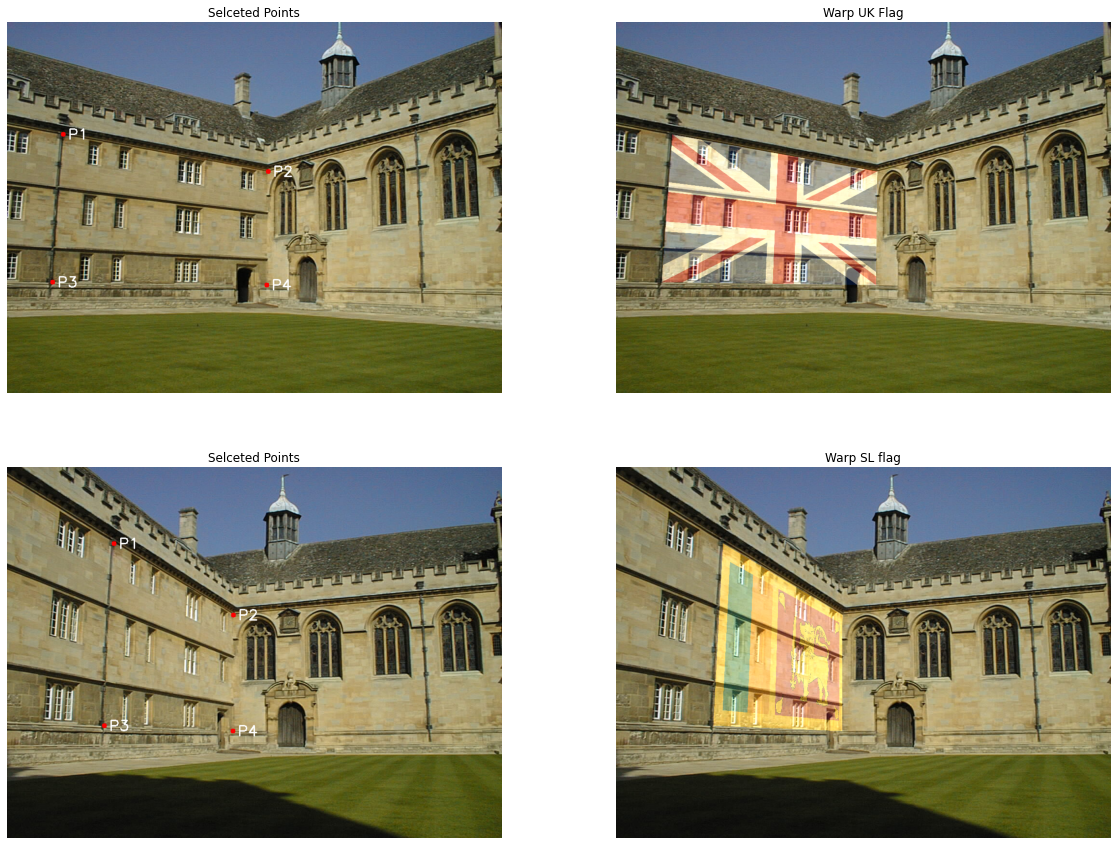

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0, 0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0, 0].set_title("Selceted Points")
ax[0, 0].axis('off')
ax[0, 1].imshow(cv.cvtColor(blend_img1, cv.COLOR_BGR2RGB))
ax[0, 1].set_title("Warp UK Flag")
ax[0, 1].axis('off')
ax[1, 0].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1, 0].set_title("Selceted Points")
ax[1, 0].axis('off')
ax[1, 1].imshow(cv.cvtColor(blend_img2, cv.COLOR_BGR2RGB))
ax[1, 1].set_title("Warp SL flag")
ax[1, 1].axis('off')

# plt.savefig('Report/images/q2.png')
plt.show()

## Question 03

In [6]:
def blend(src_img, dst_img):
    im = cv.cvtColor(src_img, cv.COLOR_BGR2GRAY)
    bw = cv.distanceTransform(im, cv.DIST_L1, cv.DIST_MASK_PRECISE)
    bw = cv.cvtColor(bw, cv.COLOR_GRAY2BGR)
    src_out = src_img * bw/bw.max()
    dst_out = dst_img * (bw.max() - bw)/bw.max()
    final = src_out + dst_out
    final = np.array(final, dtype=np.uint8)
    return final

In [7]:
def cut_and_paste(src_img, dst_img):
    im = cv.cvtColor(src_img, cv.COLOR_BGR2GRAY)
    ret,bw = cv.threshold(im,0,255,cv.THRESH_BINARY)
    bw = cv.cvtColor(bw, cv.COLOR_GRAY2BGR)
    out1 = src_img * (bw /255)
    out2 = dst_img *((255-bw)/255) 
    oo = out1 + out2
    return np.array(oo, dtype=np.uint8)

[[ 6.16676215e-01  5.32322304e-02  2.22217240e+02]
 [ 2.16676298e-01  1.14606599e+00 -2.16987118e+01]
 [ 4.77677129e-04 -5.66314728e-05  1.00000000e+00]]


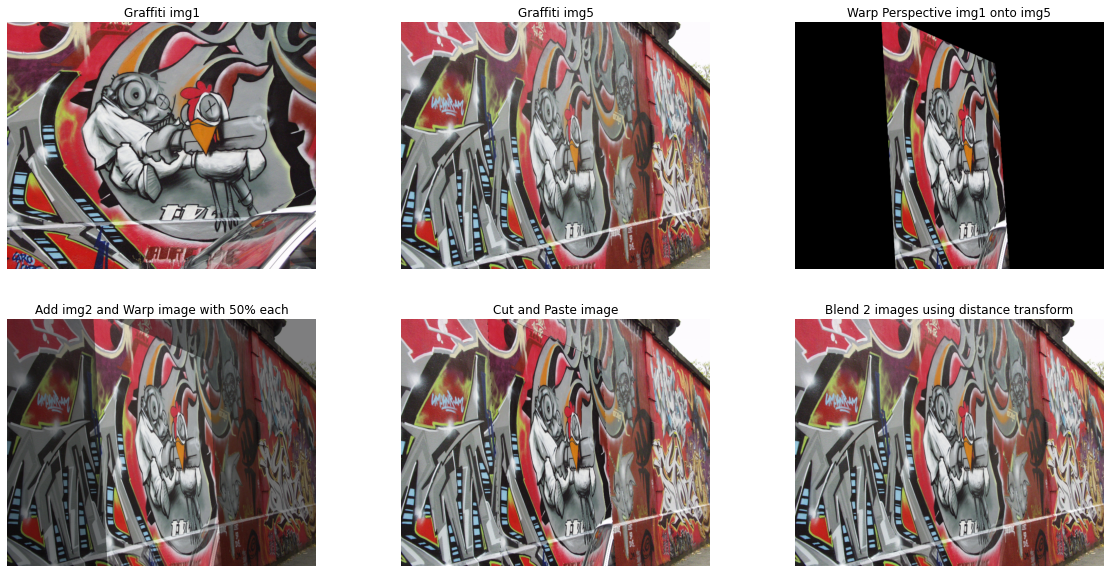

In [36]:
img1 = cv.imread('images/img1.ppm')
assert img1 is not None
img2 = cv.imread('images/img5.ppm')
assert img2 is not None
sift = cv.xfeatures2d.SIFT_create()
max_inliers = []
def ransac_homography(src_pts, dst_pts):
    best_inliers = []; best_H = None; n = len(src_pts)
    for i in range(100):
        random_index = np.random.randint(n, size=4); random_src_pts = src_pts[random_index]; random_dst_pts = dst_pts[random_index]
        H = find_hormograpy(random_src_pts, random_dst_pts) # find the homography matrix using above random 4 points
        inliers = []
        for j in range(n):
            est = H @ np.hstack((src_pts[j], 1)); est = (1/est[2])*est[:2] # get the mapping point for calculated H
            error = np.linalg.norm(est - dst_pts[j]) # get the norm of the difference vector
            if error < 10: inliers.append(j)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers; best_H = H
        if (len(best_inliers) > n*0.5):break # if there are 50% inliers, we take it as the best estimate
    return best_inliers, H
while len(max_inliers) < 50:
    pre_H = np.array([ [1, 0, 0], [0 , 1,  0], [ 0, 0, 1]], dtype=np.float64); pre_H = 1e-4 * np.random.randn(3,3) * pre_H # generate random homography
    pre_img1 = cv.warpPerspective(img1, pre_H,(1000,1000)) # apply random homography to img1
    keypoint_1, descriptor_1 = sift.detectAndCompute(pre_img1, None); keypoint_2, descriptor_2 = sift.detectAndCompute(img2, None) # get keypoints.
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5); search_params = dict(checks=100)
    flann = cv.FlannBasedMatcher(index_params,search_params); matches = flann.knnMatch(descriptor_1,descriptor_2,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance: good.append(m) # get the best matching features
    src_pts = np.float32([ keypoint_1[m.queryIdx].pt for m in good ]); dst_pts = np.float32([ keypoint_2[m.trainIdx].pt for m in good ])
    if (len(src_pts)>4): # if the matches are less than 4 we cannot find a homography. 
        inl, h = ransac_homography(src_pts, dst_pts) # get the best estimate homography for given pre_img
        if (len(inl) > len(max_inliers)):
            max_inliers = inl; best_H = pre_H; sr = src_pts[max_inliers]; ds = dst_pts[max_inliers]
H_ = find_hormograpy(sr, ds) # find the best fitting homography
H = H_ @ best_H # get the effective homography
img3 = cv.warpPerspective(img1, H, (img2.shape[1], img2.shape[0])) # appling warp perspective with effective homography
print(H/H[2][2])

fig, ax= plt.subplots(2, 3, figsize=(20,10))
ax[0, 0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0, 0].set_title("Graffiti img1")
ax[0, 1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[0, 1].set_title("Graffiti img5")
ax[0 ,2].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[0, 2].set_title("Warp Perspective img1 onto img5")
ax[1, 0].imshow(cv.cvtColor(cv.addWeighted(img2,0.5,img3,0.5,0), cv.COLOR_BGR2RGB))
ax[1, 0].set_title("Add img2 and Warp image with 50% each")
ax[1, 1].imshow(cv.cvtColor(cut_and_paste(img3, img2), cv.COLOR_BGR2RGB))
ax[1, 1].set_title("Cut and Paste image")
ax[1, 2].imshow(cv.cvtColor(blend(img3, img2), cv.COLOR_BGR2RGB))
ax[1, 2].set_title("Blend 2 images using distance transform")
for i in range(6):
    ax[i//3, i%3].axis('off')
# plt.savefig('Report/images/q3.png')
plt.show()

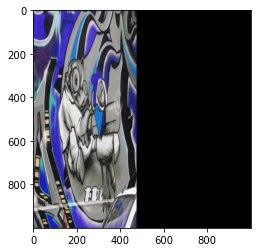

In [19]:
import cv2 as cv
img1 = cv.imread('images/img1.ppm')
assert img1 is not None
img2 = cv.imread('images/img5.ppm')
assert img2 is not None

sift = cv.xfeatures2d.SIFT_create()
keypoint_1, descriptor_1 = sift.detectAndCompute(img1, None)
keypoint_2, descriptor_2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptor_1,descriptor_2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
    
img3 = cv.drawMatches(img1,keypoint_1,img2,keypoint_2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(pre_img1)
# cv.imshow('image', pre_img1)
# cv.waitKey(0)
# cv.destroyAllWindows()
#cv.imwrite("Report/images/stif.png", img3)